In [2]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time
import joblib


np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP, FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
#from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.hypervolume import infer_reference_point
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

###########

# pymoo dependencies
import pymoo

from pymoo.factory import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.problem import Problem

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.algorithms.moo.ctaea import CTAEA

from pymoo.factory import get_sampling, get_crossover, get_mutation, get_reference_directions, get_termination
from pymoo.optimize import minimize

#from pymoo.util.termination.no_termination import NoTermination
#from pymoo.core.evaluator import set_cv

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt

from scipy.stats import gaussian_kde # for density plot

%matplotlib inline

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable

from matplotlib.ticker import StrMethodFormatter

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from matplotlib.ticker import FormatStrFormatter

In [3]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time
import joblib


np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

###########

# pymoo dependencies
import pymoo

from pymoo.factory import get_problem

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt

from scipy.stats import gaussian_kde # for density plot

from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import StrMethodFormatter

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

C:\Users\user\AppData\Local\Temp\ipykernel_2116\1997463180.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


In [5]:
def optimize_qnehvi(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, standard_bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts if q candidates fail to show improvement
                        raw_samples=128,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])
        
        ##########
        
        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, standard_bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_con, new_obj_noisy, new_con_noisy, train_x_gp, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

def optimize_nsga3(problem, ref_point, initial_x, # must haves
                   N_BATCH, pop_size,
                   ref_num=10, # as a rule of thumb, pop_size>ref_num,
                   noise=0, random_state=np.random.randint(0, 1000000, (1,)).item(), verbose=False):
    
    print("Optimizing with NSGA-III")
    
    t0 = time.time()    
    
    # some initializing
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    
    noise=noise

    # define a pymoo problem class based on the torch class
    class PymooProblem(ElementwiseProblem):

        def __init__(self):
            super().__init__(n_var=problem.n_var,
                             n_obj=problem.n_obj,
                             n_constr=problem.n_constr,
                             xl=problem.bounds[0].cpu().numpy(),
                             xu=problem.bounds[1].cpu().numpy())

        def _evaluate(self, X, out, *args, **kwargs):
            # base input/output from torch class
            train_x = torch.tensor(X.tolist(), **tkwargs).unsqueeze(dim=0)
            
            # take the noisy observations for algo
            train_obj, train_con = problem.evaluate(train_x)
            train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
            train_con_noisy = train_con + noise*torch.randn_like(train_con)

            # output the noisy observations instead
            out["F"] = -train_obj_noisy.cpu().numpy() # flip since botorch assumes maximisation vs pymoo minimization
            out["G"] = train_con_noisy.cpu().numpy()
            
    ##########        

    pymooproblem = PymooProblem()

    # create the reference directions to be used for the optimization
    ref_dirs = get_reference_directions("energy", problem.n_obj, ref_num, seed=random_state)
    
    # initial sampling
    sampling = initial_x.cpu().numpy()
    
    # create the algorithm object
    algorithm = UNSGA3(pop_size=pop_size,
                      ref_dirs=ref_dirs,
                      sampling=sampling
                     )

    # execute the optimization, take N_BATCH+1 since 1st iteration is just the initial sampling
    res = minimize(pymooproblem, algorithm, seed=random_state, termination=('n_gen', N_BATCH+1),
                   verbose=verbose, save_history=True)
    
    ##########
    
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")

    ##########
        
    # convert population data into tensor form
    # initial data
    train_x = torch.tensor(res.history[0].pop.get("X").tolist(), **tkwargs)
    train_obj, train_con = problem.evaluate(train_x) 
    # population at each iteration
    for i in range(1,N_BATCH+1): # don't forget we did +1 for total iterations
        new_x = torch.tensor(res.history[i].pop.get("X").tolist(), **tkwargs)
        new_obj, new_con = problem.evaluate(new_x)
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])

    ##########
        
    # calculate hypervolume based on checks, done on noiseless train_obj and train_con
    iterdict = {}
    a = 0
    b = initial_x.shape[0]
    for i in range(0, N_BATCH+1):

        iterdict[i] = (a, b)
        # a stays at zero
        b+=pop_size
    
    for i in range(0,N_BATCH):
        hvs_obj = train_obj[iterdict[i][0]:iterdict[i][1]]
        hvs_con = train_con[iterdict[i][0]:iterdict[i][1]]

        is_feas = (hvs_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = hvs_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
        
    print("DONE!\n")
        
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

def optimize_qnehvi_noconstr(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, standard_bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts if q candidates fail to show improvement
                        raw_samples=128,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        
        ##########
        
        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, standard_bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_obj_noisy, train_x_gp, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

def optimize_nsga3_noconstr(problem, ref_point,  initial_x, # must haves
                            N_BATCH, pop_size,
                            ref_num=10, # as a rule of thumb, pop_size>ref_num,
                            noise=0, random_state=np.random.randint(0, 1000000, (1,)).item(), verbose=False):
    
    print("Optimizing with NSGA-III")
    
    t0 = time.time()    
    
    # some initializing
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    
    noise=noise

    # define a pymoo problem class based on the torch class
    class PymooProblem(ElementwiseProblem):

        def __init__(self):
            super().__init__(n_var=problem.n_var,
                             n_obj=problem.n_obj,
                             xl=problem.bounds[0].cpu().numpy(),
                             xu=problem.bounds[1].cpu().numpy())

        def _evaluate(self, X, out, *args, **kwargs):
            # base input/output from torch class
            train_x = torch.tensor(X.tolist(), **tkwargs).unsqueeze(dim=0)
            
            # take the noisy observations for algo
            train_obj = problem.evaluate(train_x)
            train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)

            # output the noisy observations instead
            out["F"] = -train_obj_noisy.cpu().numpy() # flip since botorch assumes maximisation vs pymoo minimization
            
    ##########        

    pymooproblem = PymooProblem()

    # create the reference directions to be used for the optimization
    ref_dirs = get_reference_directions("energy", problem.n_obj, ref_num, seed=random_state)
    
    # initial sampling
    sampling = initial_x.cpu().numpy()
    
    # create the algorithm object
    algorithm = UNSGA3(pop_size=pop_size,
                      ref_dirs=ref_dirs,
                      sampling=sampling
                     )

    # execute the optimization, take N_BATCH+1 since 1st iteration is just the initial sampling
    res = minimize(pymooproblem, algorithm, seed=random_state, termination=('n_gen', N_BATCH+1),
                   verbose=verbose, save_history=True)
    
    ##########
    
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")
    
    ##########
    
    # convert population data into tensor form
    # initial data
    train_x = torch.tensor(res.history[0].pop.get("X").tolist(), **tkwargs)
    train_obj = problem.evaluate(train_x) 
    # population at each iteration
    for i in range(1,N_BATCH+1): # don't forget we did +1 for total iterations
        new_x = torch.tensor(res.history[i].pop.get("X").tolist(), **tkwargs)
        new_obj = problem.evaluate(new_x)
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        
    ##########
    
    # calculate hypervolume based on checks, done on noiseless train_obj and train_con
    iterdict = {}
    a = 0
    b = initial_x.shape[0]
    for i in range(0, N_BATCH+1):

        iterdict[i] = (a, b)
        # a stays at zero
        b+=pop_size
    
    for i in range(0,N_BATCH):
        hvs_obj = train_obj[iterdict[i][0]:iterdict[i][1]]

        # computing HV of current candidate list
        pareto_mask = is_non_dominated(hvs_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = hvs_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
                
        hvs.append(volume)   
        
    ##########
     
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [4]:
dimensions = 8

from botorch.test_functions.multi_objective import ZDT1

ZDT1base = ZDT1(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT1(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 1 # inequality constraints only!
        
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT1base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
from botorch.test_functions.multi_objective import ZDT2

ZDT2base = ZDT2(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT2(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 1 # inequality constraints only!
        
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT2base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
from botorch.test_functions.multi_objective import ZDT3

ZDT3base = ZDT3(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT3(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 1 # inequality constraints only!
        
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT3base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
from botorch.test_functions.multi_objective import C2DTLZ2

LZ2base = C2DTLZ2(dim=dimensions, num_objectives=2, negate=True).to(**tkwargs)

class Problem_LZ2(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 1
    
    bounds = LZ2base.bounds    
    
    def evaluate(X):       
        output = LZ2base(X)
        slack = -LZ2base.evaluate_slack(X)
       
        return output, slack
    
from botorch.test_functions.multi_objective import MW7

MW7base = MW7(dim=dimensions, negate=True).to(**tkwargs)

class Problem_MW7(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 1
    
    bounds = LZ2base.bounds    
    
    def evaluate(X):       
        output = MW7base(X)
        slack = -MW7base.evaluate_slack(X)
       
        return output, slack
    
class MWBase(torch.nn.Module):   
    def g3(X, n_obj):
        contrib = 2.0 * torch.pow(
            X[:, n_obj - 1:] + (X[:, n_obj - 2:-1] - 0.5) * (X[:, n_obj - 2:-1] - 0.5) - 1.0, 2.0)
        
        distance = 1 + contrib.sum(axis=1)
        return distance
    
    def LA1(A, B, C, D, theta):
        return A * torch.pow(torch.sin(B * np.pi * torch.pow(theta, C)), D)

    def LA2(A, B, C, D, theta):
        return A * torch.pow(torch.sin(B * torch.pow(theta, C)), D)

class Problem_MW3(torch.nn.Module):
    # must define these!
    n_var = dimensions
    n_obj = 2
    n_constr = 2 # inequality constraints only!
        
    # input bounds, don't forget to change according to n_var!  
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):
        
        # objectives are defined by f1, f2....
        # if you have complex equations, you can break it up and place them in ProblemBase for convenience, not compulsory
        # otherwise, you could place an oracle here that outputs the objective
        g = MWBase.g3(X, n_obj=2)
        f1 = X[:, 0]
        f2 = g * (1.0 - f1 / g)
        
        # inequality constraints should take the form of c(n)<=0
        # for equality constraints, either use the equality constr argument, or rewrite into inequality form (preferred)
        # if no constraints, write as c1 = 0 * X[..., 0], and set n_constr=1     
        c1 = f1 + f2 - 1.05 - MWBase.LA1(0.45, 0.75, 1.0, 6.0, np.sqrt(2.0) * f2 - np.sqrt(2.0) * f1)
        c2 = 0.85 - f1 - f2 + MWBase.LA1(0.3, 0.75, 1.0, 2.0, np.sqrt(2.0) * f2 - np.sqrt(2.0) * f1)
        
        # botorch assumes maximisation
        # to maximise a postive output, stay positive
        # to minimise a positive output, force negative
        # to maximise a negative output (away from zero), force positive
        # to minimise a negative output (towards zero), stay negative
        output = torch.stack([-f1, -f2], dim=-1)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        slack = torch.stack([c1, c2], dim=-1)
        
        return output, slack
    
diff1 = 0
diff2 = 0.5
diff3 = 0.5

class Problem_DAS1(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 11
    bounds = torch.stack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    #ref_point = LZ2.ref_point # make sure sign follows output
    
    def evaluate(X):
        g = torch.zeros(X.shape[0], **tkwargs)
        for i in range(X.shape[1]):
            g += torch.pow(X[...,i] - torch.sin(0.5 * np.pi * X[...,0]), 2)

        f1 = X[...,0] + g
        f2 = 1.0 - torch.pow(X[...,0], 2) + g
        
        #################
        
        a = 20
        b = 2 * diff1 - 1.
        d = 0.5 if diff2 != 0 else 0
        if diff2 > 0:
            e = d - torch.log(torch.tensor(diff2, **tkwargs))
        else:
            e = 1e30
        r = 0.5 * diff3

        p_k = [0., 1.0, 0., 1.0, 2.0, 0., 1.0, 2.0, 3.0]
        q_k = [1.5, 0.5, 2.5, 1.5, 0.5, 3.5, 2.5, 1.5, 0.5]

        a_k2 = 0.3
        b_k2 = 1.2
        theta_k = torch.tensor(-0.25 * np.pi, **tkwargs)

        c = torch.zeros((X.shape[0], 11), **tkwargs)

        c[...,0] = torch.sin(a * np.pi * X[...,0]) - b

        if diff2 == 1:
            c[...,1] = 1e-4 - torch.abs(e - g, **tkwargs)
        else:
            c[...,1] = (e - g) * (g - d)

        for i in range(2, 11):
            c[...,i] = ((f1 - p_k[i-2]) * torch.cos(theta_k) - (f2 - q_k[i-2]) * torch.sin(theta_k)) ** 2 / a_k2 + ((f1 - p_k[i-2]) * torch.sin(theta_k) + (f2 - q_k[i-2]) * torch.cos(theta_k)) ** 2 / b_k2 - r


        ####################
        
        # to maximise a postive output, stay positive
        # to minimise a positive output, force negative
        # to maximise a negative output (away from zero), force positive
        # to minimise a negative output (towards zero), stay negative
        output = torch.stack([-f1, -f2], dim=-1)
        
        # constraint equations should take the form of c(n)<=0
        # should return <=0 values when constraints are active,
        # and >0 values when constraints are violated
        slack = -c    
        
        return output, slack

#assert Problem.n_obj == Problem.ref_point.size(dim=-1) == Problem.evaluate(torch.ones(1, Problem.n_var, **tkwargs))[0].size(dim=-1),"Number of objectives, n_obj and reference point should match!"
#assert Problem.n_constr == Problem.evaluate(torch.ones(1, Problem.n_var, **tkwargs))[1].size(dim=-1), "Number of constraints and n_constr should match!"

In [ ]:
ref_point = torch.tensor([11,11], **tkwargs)
verbose = True
noise = 0.00
problem = Problem_ZDT1

problem1 = get_problem("zdt1")
pareto = problem1.pareto_front()

trial = 1

N_BATCH = 100
BATCH_SIZE = 8

initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

hvs_qnehvi, train_qnehvi = optimize_qnehvi_noconstr(problem, ref_point, initial_x,
                                                    N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                                                    random_state=trial, noise=noise, verbose=verbose)

hvs_nsga3, train_nsga3 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=N_BATCH, pop_size=BATCH_SIZE, ref_num=BATCH_SIZE,
                                                 random_state=trial, noise=noise, verbose=False)


savetxt("ZDT1_hvs_nsga3_100by8.csv", hvs_nsga3, delimiter=',')
savetxt("ZDT1_hvs_qnehvi_100by8.csv", hvs_qnehvi, delimiter=',')

savetxt("ZDT1_train_qnehvi_100by8.csv", np.array(train_qnehvi).reshape(-1), delimiter=',')
savetxt("ZDT1_train_nsga3_100by8.csv", np.array(train_nsga3).reshape(-1), delimiter=',')

C:\Users\user\AppData\Local\Temp\ipykernel_67764\801492819.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("zdt1")
C:\Users\user\AppData\Local\Temp\ipykernel_67764\801492819.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


Text(0.5, 1.0, 'Iteration')

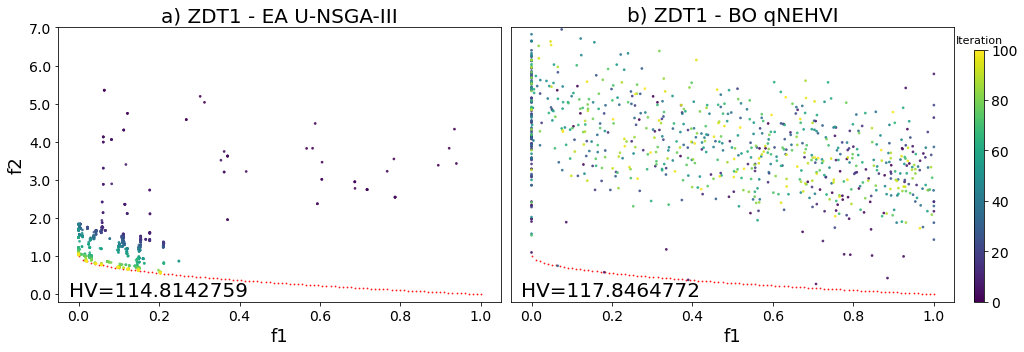

In [20]:
N_BATCH = 100
BATCH_SIZE = 8

problem = Problem_ZDT1
problem1 = get_problem("zdt1")
pareto = problem1.pareto_front()

hvs_nsga3 = loadtxt("ZDT1_hvs_nsga3_100by8.csv", delimiter=',')
hvs_qnehvi = loadtxt("ZDT1_hvs_qnehvi_100by8.csv", delimiter=',')

train_qnehvi = loadtxt("ZDT1_train_qnehvi_100by8.csv", delimiter=',')
train_nsga3 = loadtxt("ZDT1_train_nsga3_100by8.csv",  delimiter=',')

train_qnehvi = np.array(train_qnehvi).reshape((N_BATCH*BATCH_SIZE)+2*(dimensions+1), dimensions+2)    
train_nsga3 = np.array(train_nsga3).reshape((N_BATCH*BATCH_SIZE)+2*(dimensions+1), dimensions+2)

cm = plt.cm.get_cmap('viridis')

fig, ax = plt.subplots(ncols = 2, figsize = (14,5))

algos = ['EA U-NSGA-III', 'BO qNEHVI']

batch_number = torch.cat([torch.zeros(2*(problem.n_var+1)),
                          torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)
                         ]).numpy()

for i, train, letter in zip([0,1],
                            [train_nsga3, train_qnehvi],
                            ['a', 'b']):

    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=3, marker=".", alpha=0.8)
    
    ax[i].scatter(-train[...,problem.n_var:problem.n_var+problem.n_obj][:,0],
                  -train[...,problem.n_var:problem.n_var+problem.n_obj][:,1],
                 c=batch_number, cmap=cm, s=3, alpha=0.8)

    ax[i].set_title(f"{letter}) ZDT1 - {algos[i]}", fontsize=20)
    ax[i].set_xlabel('f1')
    
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
    
    ax[i].set_xlim(-0.05, 1.05)
    ax[i].set_ylim(-0.2, 7)

ax[0].set_ylabel('f2')

ax[0].text(-0.025, -0.05, f"HV={hvs_nsga3[-1]:.7f}", fontsize=20)
ax[1].text(-0.025, -0.05, f"HV={hvs_qnehvi[-1]:.7f}", fontsize=20)
ax[1].set(ylabel=None, yticklabels=[])
ax[1].tick_params(left=False)

ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


#plt.setp(ax, xlim=ax[1].get_xlim(), ylim=ax[1].get_ylim())

fig.tight_layout()

norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration", fontsize=11)

In [31]:
fig.savefig('trajectory_ZDT1.pdf')

In [9]:
ref_point = torch.tensor([11,11], **tkwargs)
verbose = True
noise = 0.00
problem = Problem_ZDT2

problem1 = get_problem("zdt2")
pareto = problem1.pareto_front()

trial = 1

N_BATCH = 100
BATCH_SIZE = 8

initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

hvs_qnehvi, train_qnehvi = optimize_qnehvi_noconstr(problem, ref_point, initial_x,
                                                    N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                                                    random_state=trial, noise=noise, verbose=verbose)

hvs_nsga3, train_nsga3 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=N_BATCH, pop_size=BATCH_SIZE, ref_num=BATCH_SIZE,
                                                 random_state=trial, noise=noise, verbose=False)

Optimizing with qNEHVI
Batch  1 of 100: Hypervolume = 76.22, time = 5.31s.
Batch  2 of 100: Hypervolume = 86.23, time = 6.47s.
Batch  3 of 100: Hypervolume = 97.66, time = 7.39s.
Batch  4 of 100: Hypervolume = 107.70, time = 5.88s.
Batch  5 of 100: Hypervolume = 108.48, time = 5.70s.
Batch  6 of 100: Hypervolume = 119.85, time = 6.59s.
Batch  7 of 100: Hypervolume = 120.00, time = 7.34s.
Batch  8 of 100: Hypervolume = 120.00, time = 7.16s.
Batch  9 of 100: Hypervolume = 120.00, time = 7.40s.
Batch 10 of 100: Hypervolume = 120.00, time = 8.25s.
Batch 11 of 100: Hypervolume = 120.00, time = 7.56s.
Batch 12 of 100: Hypervolume = 120.00, time = 7.60s.
Batch 13 of 100: Hypervolume = 120.00, time = 8.08s.
Batch 14 of 100: Hypervolume = 120.00, time = 2.02s.
Batch 15 of 100: Hypervolume = 120.00, time = 9.02s.
Batch 16 of 100: Hypervolume = 120.00, time = 7.65s.
Batch 17 of 100: Hypervolume = 120.00, time = 7.87s.
Batch 18 of 100: Hypervolume = 120.00, time = 8.10s.
Batch 19 of 100: Hypervolu

In [11]:
savetxt("ZDT2_hvs_nsga3_100by8.csv", hvs_nsga3, delimiter=',')
savetxt("ZDT2_hvs_qnehvi_100by8.csv", hvs_qnehvi, delimiter=',')

savetxt("ZDT2_train_qnehvi_100by8.csv", np.array(train_qnehvi).reshape(-1), delimiter=',')
savetxt("ZDT2_train_nsga3_100by8.csv", np.array(train_nsga3).reshape(-1), delimiter=',')

C:\Users\user\AppData\Local\Temp\ipykernel_67764\2472031218.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("zdt2")
C:\Users\user\AppData\Local\Temp\ipykernel_67764\2472031218.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


Text(0.5, 1.0, 'Iteration')

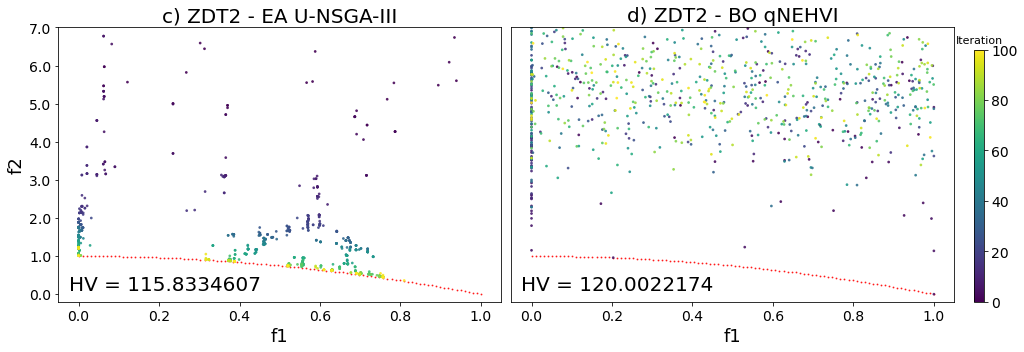

In [19]:
N_BATCH = 100
BATCH_SIZE = 8

problem = Problem_ZDT2
problem1 = get_problem("zdt2")
pareto = problem1.pareto_front()

hvs_nsga3 = loadtxt("ZDT2_hvs_nsga3_100by8.csv", delimiter=',')
hvs_qnehvi = loadtxt("ZDT2_hvs_qnehvi_100by8.csv", delimiter=',')

train_qnehvi = loadtxt("ZDT2_train_qnehvi_100by8.csv", delimiter=',')
train_nsga3 = loadtxt("ZDT2_train_nsga3_100by8.csv",  delimiter=',')

train_qnehvi = np.array(train_qnehvi).reshape((N_BATCH*BATCH_SIZE)+2*(dimensions+1), dimensions+2)    
train_nsga3 = np.array(train_nsga3).reshape((N_BATCH*BATCH_SIZE)+2*(dimensions+1), dimensions+2)

cm = plt.cm.get_cmap('viridis')

fig, ax = plt.subplots(ncols = 2, figsize = (14,5))

algos = ['EA U-NSGA-III', 'BO qNEHVI']

batch_number = torch.cat([torch.zeros(2*(problem.n_var+1)),
                          torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)
                         ]).numpy()

for i, train, letter in zip([0,1],
                            [train_nsga3, train_qnehvi],
                            ['c', 'd']):

    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=3, marker=".", alpha=0.8)
    
    ax[i].scatter(-train[...,problem.n_var:problem.n_var+problem.n_obj][:,0],
                  -train[...,problem.n_var:problem.n_var+problem.n_obj][:,1],
                 c=batch_number, cmap=cm, s=3, alpha=0.8)

    ax[i].set_title(f"{letter}) ZDT2 - {algos[i]}", fontsize=20)
    ax[i].set_xlabel('f1')
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

    
    ax[i].set_xlim(-0.05, 1.05)
    ax[i].set_ylim(-0.2, 7.0)

ax[0].set_ylabel('f2')

ax[0].text(-0.025, 0.1, f"HV = {hvs_nsga3[-1]:.7f}", fontsize=20)
ax[1].text(-0.025, 0.1, f"HV = {hvs_qnehvi[-1]:.7f}", fontsize=20)
ax[1].set(ylabel=None, yticklabels=[])
ax[1].tick_params(left=False)

ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


#plt.setp(ax, xlim=ax[1].get_xlim(), ylim=ax[1].get_ylim())

fig.tight_layout()

norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration", fontsize=11)

In [33]:
fig.savefig('trajectory_ZDT2.pdf')

In [14]:
ref_point = torch.tensor([11,11], **tkwargs)
verbose = True
noise = 0.00
problem = Problem_ZDT3

problem1 = get_problem("zdt3")
pareto = problem1.pareto_front()

trial = 1

N_BATCH = 100
BATCH_SIZE = 8

initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

hvs_qnehvi, train_qnehvi = optimize_qnehvi_noconstr(problem, ref_point, initial_x,
                                                    N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                                                    random_state=trial, noise=noise, verbose=verbose)

hvs_nsga3, train_nsga3 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=N_BATCH, pop_size=BATCH_SIZE, ref_num=BATCH_SIZE,
                                                 random_state=trial, noise=noise, verbose=False)

savetxt("ZDT3_hvs_nsga3_100by8.csv", hvs_nsga3, delimiter=',')
savetxt("ZDT3_hvs_qnehvi_100by8.csv", hvs_qnehvi, delimiter=',')

savetxt("ZDT3_train_qnehvi_100by8.csv", np.array(train_qnehvi).reshape(-1), delimiter=',')
savetxt("ZDT3_train_nsga3_100by8.csv", np.array(train_nsga3).reshape(-1), delimiter=',')

Optimizing with qNEHVI
Batch  1 of 100: Hypervolume = 114.03, time = 6.32s.
Batch  2 of 100: Hypervolume = 115.58, time = 6.76s.
Batch  3 of 100: Hypervolume = 115.84, time = 7.58s.
Batch  4 of 100: Hypervolume = 116.18, time = 9.44s.
Batch  5 of 100: Hypervolume = 116.71, time = 9.96s.
Batch  6 of 100: Hypervolume = 117.72, time = 10.24s.
Batch  7 of 100: Hypervolume = 120.22, time = 11.55s.
Batch  8 of 100: Hypervolume = 121.21, time = 11.27s.
Batch  9 of 100: Hypervolume = 121.22, time = 10.39s.
Batch 10 of 100: Hypervolume = 121.31, time = 10.53s.
Batch 11 of 100: Hypervolume = 121.35, time = 10.02s.
Batch 12 of 100: Hypervolume = 121.36, time = 11.17s.
Batch 13 of 100: Hypervolume = 121.36, time = 10.77s.
Batch 14 of 100: Hypervolume = 121.36, time = 8.80s.
Batch 15 of 100: Hypervolume = 121.36, time = 11.36s.
Batch 16 of 100: Hypervolume = 121.36, time = 11.07s.
Batch 17 of 100: Hypervolume = 121.36, time = 13.33s.
Batch 18 of 100: Hypervolume = 121.36, time = 13.13s.
Batch 19 of

C:\Users\user\AppData\Local\Temp\ipykernel_67764\1250279603.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("zdt3")
C:\Users\user\AppData\Local\Temp\ipykernel_67764\1250279603.py:17: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("zdt3")
C:\Users\user\AppData\Local\Temp\ipykernel_67764\1250279603.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


Text(0.5, 1.0, 'Iteration')

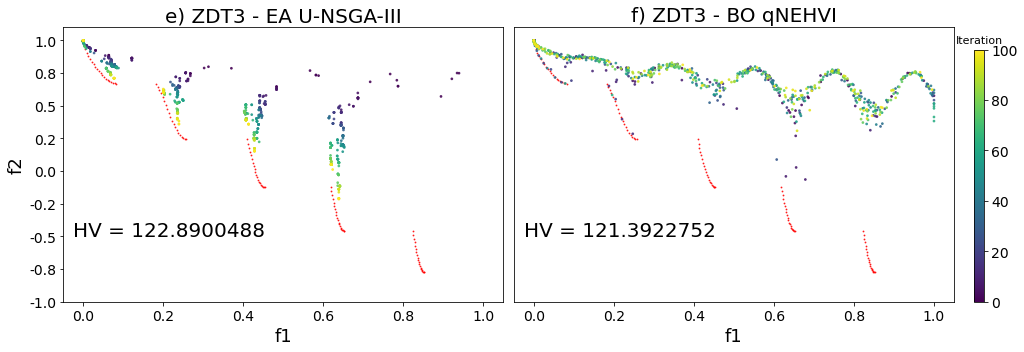

In [21]:
N_BATCH = 100
BATCH_SIZE = 8

problem = Problem_ZDT3
problem1 = get_problem("zdt3")
pareto = problem1.pareto_front()

hvs_nsga3 = loadtxt("ZDT3_hvs_nsga3_100by8.csv", delimiter=',')
hvs_qnehvi = loadtxt("ZDT3_hvs_qnehvi_100by8.csv", delimiter=',')

train_qnehvi = loadtxt("ZDT3_train_qnehvi_100by8.csv", delimiter=',')
train_nsga3 = loadtxt("ZDT3_train_nsga3_100by8.csv",  delimiter=',')

train_qnehvi = np.array(train_qnehvi).reshape((N_BATCH*BATCH_SIZE)+2*(dimensions+1), dimensions+2)    
train_nsga3 = np.array(train_nsga3).reshape((N_BATCH*BATCH_SIZE)+2*(dimensions+1), dimensions+2)

problem1 = get_problem("zdt3")
pareto = problem1.pareto_front()

cm = plt.cm.get_cmap('viridis')

fig, ax = plt.subplots(ncols = 2, figsize = (14,5))

algos = ['EA U-NSGA-III', 'BO qNEHVI']

batch_number = torch.cat([torch.zeros(2*(problem.n_var+1)),
                          torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)
                         ]).numpy()

for i, train, letter in zip([0,1],
                            [train_nsga3, train_qnehvi],
                            ['e', 'f']):
    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=3, marker=".", alpha=0.8)
    
    ax[i].scatter(-train[...,problem.n_var:problem.n_var+problem.n_obj][:,0],
                  -train[...,problem.n_var:problem.n_var+problem.n_obj][:,1],
                 c=batch_number, cmap=cm, s=3, alpha=0.8)

    ax[i].set_title(f"{letter}) ZDT3 - {algos[i]}", fontsize=20)
    ax[i].set_xlabel('f1')
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places

    
    ax[i].set_xlim(-0.05, 1.05)
    ax[i].set_ylim(-1.0, 1.1)

ax[0].set_ylabel('f2')

ax[0].text(-0.025, -0.5, f"HV = {hvs_nsga3[-1]:.7f}", fontsize=20)
ax[1].text(-0.025, -0.5, f"HV = {hvs_qnehvi[-1]:.7f}", fontsize=20)
ax[1].set(ylabel=None, yticklabels=[])
ax[1].tick_params(left=False)

ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

#plt.setp(ax, xlim=ax[1].get_xlim(), ylim=ax[1].get_ylim())

fig.tight_layout()

norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration", fontsize=11)

In [35]:
fig.savefig('trajectory_ZDT3.pdf')

In [18]:
ref_point = torch.tensor([1.2,1.2], **tkwargs)
verbose = True
noise = 0.00
problem = Problem_MW7

problem1 = get_problem("mw7")
pareto = problem1.pareto_front()

trial = 1

N_BATCH = 100
BATCH_SIZE = 8

initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

hvs_qnehvi, train_qnehvi = optimize_qnehvi(problem, ref_point, initial_x,
                                                    N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                                                    random_state=trial, noise=noise, verbose=verbose)

hvs_nsga3, train_nsga3 = optimize_nsga3(problem, ref_point, initial_x,
                                                 N_BATCH=N_BATCH, pop_size=BATCH_SIZE, ref_num=BATCH_SIZE,
                                                 random_state=trial, noise=noise, verbose=False)

savetxt("MW7_hvs_nsga3_100by8.csv", hvs_nsga3, delimiter=',')
savetxt("MW7_hvs_qnehvi_100by8.csv", hvs_qnehvi, delimiter=',')

savetxt("MW7_train_qnehvi_100by8.csv", np.array(train_qnehvi).reshape(-1), delimiter=',')
savetxt("MW7_train_nsga3_100by8.csv", np.array(train_nsga3).reshape(-1), delimiter=',')

Optimizing with qNEHVI
Batch  1 of 100: Hypervolume = 0.00, time = 1.22s.
Batch  2 of 100: Hypervolume = 0.00, time = 4.44s.
Batch  3 of 100: Hypervolume = 0.21, time = 15.63s.
Batch  4 of 100: Hypervolume = 0.21, time = 16.39s.
Batch  5 of 100: Hypervolume = 0.21, time = 13.68s.
Batch  6 of 100: Hypervolume = 0.22, time = 14.34s.
Batch  7 of 100: Hypervolume = 0.22, time = 14.87s.
Batch  8 of 100: Hypervolume = 0.22, time = 14.96s.
Batch  9 of 100: Hypervolume = 0.22, time = 11.81s.
Batch 10 of 100: Hypervolume = 0.22, time = 12.89s.
Batch 11 of 100: Hypervolume = 0.22, time = 13.60s.
Batch 12 of 100: Hypervolume = 0.22, time = 13.60s.
Batch 13 of 100: Hypervolume = 0.22, time = 12.64s.
Batch 14 of 100: Hypervolume = 0.22, time = 11.89s.
Batch 15 of 100: Hypervolume = 0.22, time = 15.74s.
Batch 16 of 100: Hypervolume = 0.22, time = 2.09s.
Batch 17 of 100: Hypervolume = 0.22, time = 12.41s.
Batch 18 of 100: Hypervolume = 0.22, time = 2.26s.
Batch 19 of 100: Hypervolume = 0.30, time = 6

C:\Users\user\AppData\Local\Temp\ipykernel_67764\2934173201.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("mw7")
C:\Users\user\AppData\Local\Temp\ipykernel_67764\2934173201.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


Text(0.5, 1.0, 'Iteration')

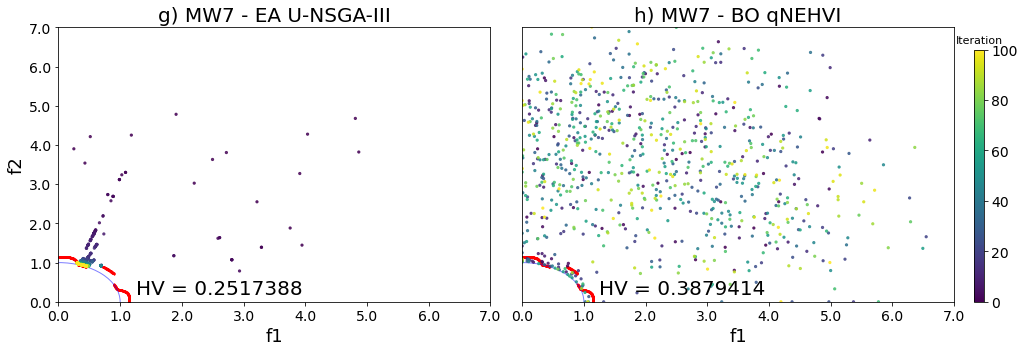

In [26]:
N_BATCH = 100
BATCH_SIZE = 8

problem = Problem_MW7
problem1 = get_problem("mw7")
pareto = problem1.pareto_front()

hvs_nsga3 = loadtxt("MW7_hvs_nsga3_100by8.csv", delimiter=',')
hvs_qnehvi = loadtxt("MW7_hvs_qnehvi_100by8.csv", delimiter=',')

train_qnehvi = loadtxt("MW7_train_qnehvi_100by8.csv", delimiter=',')
train_nsga3 = loadtxt("MW7_train_nsga3_100by8.csv",  delimiter=',')

train_qnehvi = np.array(train_qnehvi).reshape((N_BATCH*BATCH_SIZE)+2*(dimensions+1), dimensions+2+2)    
train_nsga3 = np.array(train_nsga3).reshape((N_BATCH*BATCH_SIZE)+2*(dimensions+1), dimensions+2+2)

cm = plt.cm.get_cmap('viridis')

fig, ax = plt.subplots(ncols = 2, figsize = (14,5))

algos = ['EA U-NSGA-III', 'BO qNEHVI']

batch_number = torch.cat([torch.zeros(2*(problem.n_var+1)),
                          torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)
                         ]).numpy()

for i, train, letter in zip([0,1],
                            [train_nsga3, train_qnehvi],
                            ['g', 'h']):
    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=3, marker=".", alpha=0.8)
    
    ax[i].add_patch(plt.Circle((0, 0), 1, color='b', fill=False, alpha=0.5))

    
    ax[i].scatter(-train[...,problem.n_var:problem.n_var+problem.n_obj][:,0],
                  -train[...,problem.n_var:problem.n_var+problem.n_obj][:,1],
                 c=batch_number, cmap=cm, s=5, alpha=0.8)
    

    ax[i].set_title(f"{letter}) MW7 - {algos[i]}", fontsize=20)
    ax[i].set_xlabel('f1')
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

    ax[i].set_xlim(-0, 7)
    ax[i].set_ylim(-0, 7)

ax[0].set_ylabel('f2')

ax[0].text(1.25, 0.2, f"HV = {hvs_nsga3[-1]:.7f}", fontsize=20)
ax[1].text(1.25, 0.2, f"HV = {hvs_qnehvi[-1]:.7f}", fontsize=20)
ax[1].set(ylabel=None, yticklabels=[])
ax[1].tick_params(left=False)

ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

#plt.setp(ax, xlim=ax[1].get_xlim(), ylim=ax[1].get_ylim())

fig.tight_layout()

norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration", fontsize=11)

In [37]:
fig.savefig('trajectory_MW7.pdf')

In [65]:
ref_point = torch.tensor([1.1,1.1], **tkwargs)
verbose = True
noise = 0.00
problem = Problem_ZDT1

problem1 = get_problem("zdt1")
pareto = problem1.pareto_front()

trial = 1

initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

hvs_nsga30, train_nsga30 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=400, pop_size=2, ref_num=2,
                                                 random_state=trial, noise=noise, verbose=False)
hvs_nsga31, train_nsga31 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=200, pop_size=4, ref_num=4,
                                                 random_state=trial, noise=noise, verbose=False)
hvs_nsga32, train_nsga32 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=100, pop_size=8, ref_num=8,
                                                 random_state=trial, noise=noise, verbose=False)
hvs_nsga33, train_nsga33 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=50, pop_size=16, ref_num=16,
                                                 random_state=trial, noise=noise, verbose=False)

Optimizing with NSGA-III
Time taken in total: 2.23s.
Optimizing with NSGA-III
Time taken in total: 1.80s.
Optimizing with NSGA-III
Time taken in total: 1.76s.
Optimizing with NSGA-III
Time taken in total: 1.73s.


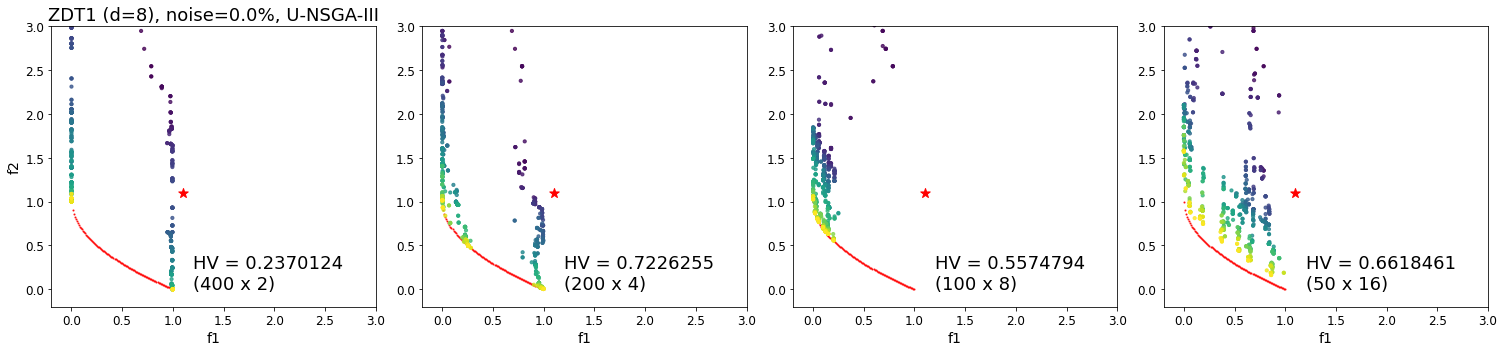

In [66]:
fig, ax = plt.subplots(ncols = 4, figsize = (21,5))

col_list = [0, 1, 2, 3]
train_list = [train_nsga30, train_nsga31, train_nsga32, train_nsga33]
hvs_list = [hvs_nsga30, hvs_nsga31, hvs_nsga32, hvs_nsga33]
n_batch_list = [400, 200, 100, 50]
batch_size_list = [2, 4, 8, 16]

for i, train, hvs, n_batch, batch_size in zip(col_list, train_list, hvs_list, n_batch_list, batch_size_list):
    
    batch_number = torch.cat([torch.zeros(2*(problem.n_var+1)),
                          torch.arange(1, n_batch+1).repeat(batch_size, 1).t().reshape(-1)
                         ]).numpy()

    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=5, marker=".", alpha=0.8)
    
    ax[i].scatter(-train[...,problem.n_var:problem.n_var+problem.n_obj][:,0],
                  -train[...,problem.n_var:problem.n_var+problem.n_obj][:,1],
                 c=batch_number, s=10, alpha=0.8)

    ax[i].scatter(ref_point.cpu().numpy()[0],
                  ref_point.cpu().numpy()[1], 
                  c="r", s=100, marker="*")
    
    ax[i].text(1.2, 0, f"HV = {hvs[-1]:.7f}\n({n_batch} x {batch_size})", fontsize=18)
    
    ax[i].set_xlabel('f1', fontsize=14)
    
    ax[i].set_xlim(-0.2, 3)
    ax[i].set_ylim(-0.2, 3)
    
ax[0].set_title(f"ZDT1 (d={dimensions}), noise={noise*100}%, U-NSGA-III", fontsize=18)
ax[0].set_ylabel('f2', fontsize=14)

fig.tight_layout()

In [67]:
ref_point = torch.tensor([1.1,1.1], **tkwargs)
verbose = True
noise = 0.00
problem = Problem_ZDT2

problem1 = get_problem("zdt2")
pareto = problem1.pareto_front()

trial = 1

initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

hvs_nsga30, train_nsga30 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=400, pop_size=2, ref_num=2,
                                                 random_state=trial, noise=noise, verbose=False)
hvs_nsga31, train_nsga31 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=200, pop_size=4, ref_num=4,
                                                 random_state=trial, noise=noise, verbose=False)
hvs_nsga32, train_nsga32 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=100, pop_size=8, ref_num=8,
                                                 random_state=trial, noise=noise, verbose=False)
hvs_nsga33, train_nsga33 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=50, pop_size=16, ref_num=16,
                                                 random_state=trial, noise=noise, verbose=False)

Optimizing with NSGA-III
Time taken in total: 2.12s.
Optimizing with NSGA-III
Time taken in total: 1.77s.
Optimizing with NSGA-III
Time taken in total: 2.65s.
Optimizing with NSGA-III
Time taken in total: 1.77s.


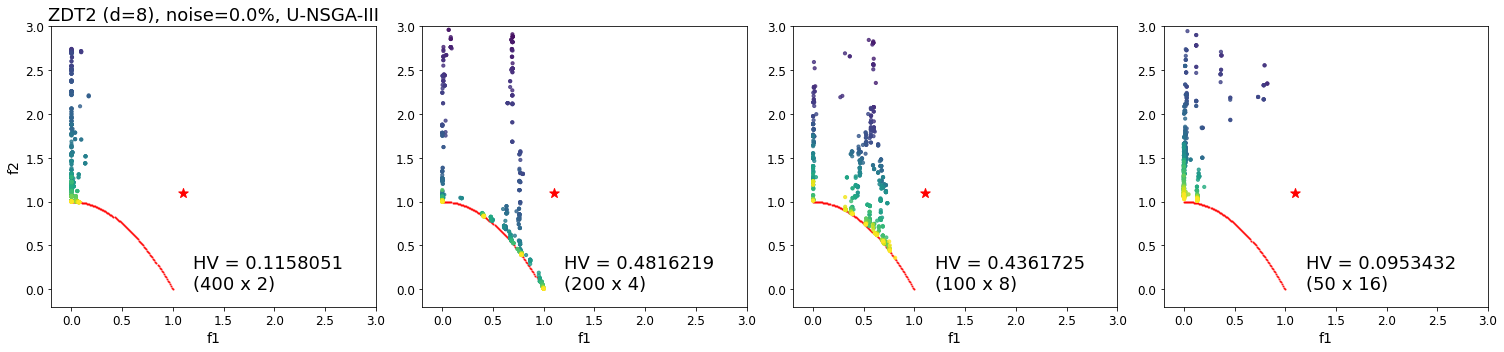

In [68]:
fig, ax = plt.subplots(ncols = 4, figsize = (21,5))

col_list = [0, 1, 2, 3]
train_list = [train_nsga30, train_nsga31, train_nsga32, train_nsga33]
hvs_list = [hvs_nsga30, hvs_nsga31, hvs_nsga32, hvs_nsga33]
n_batch_list = [400, 200, 100, 50]
batch_size_list = [2, 4, 8, 16]

for i, train, hvs, n_batch, batch_size in zip(col_list, train_list, hvs_list, n_batch_list, batch_size_list):
    
    batch_number = torch.cat([torch.zeros(2*(problem.n_var+1)),
                          torch.arange(1, n_batch+1).repeat(batch_size, 1).t().reshape(-1)
                         ]).numpy()

    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=5, marker=".", alpha=0.8)
    
    ax[i].scatter(-train[...,problem.n_var:problem.n_var+problem.n_obj][:,0],
                  -train[...,problem.n_var:problem.n_var+problem.n_obj][:,1],
                 c=batch_number, s=10, alpha=0.8)

    ax[i].scatter(ref_point.cpu().numpy()[0],
                  ref_point.cpu().numpy()[1], 
                  c="r", s=100, marker="*")
    
    ax[i].text(1.2, 0, f"HV = {hvs[-1]:.7f}\n({n_batch} x {batch_size})", fontsize=18)
    
    ax[i].set_xlabel('f1', fontsize=14)
    
    ax[i].set_xlim(-0.2, 3)
    ax[i].set_ylim(-0.2, 3)
    
ax[0].set_title(f"ZDT2 (d={dimensions}), noise={noise*100}%, U-NSGA-III", fontsize=18)
ax[0].set_ylabel('f2', fontsize=14)

fig.tight_layout()

In [69]:
ref_point = torch.tensor([1.1,1.1], **tkwargs)
verbose = True
noise = 0.00
problem = Problem_ZDT3

problem1 = get_problem("zdt3")
pareto = problem1.pareto_front()

trial = 1

initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

hvs_nsga30, train_nsga30 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=400, pop_size=2, ref_num=2,
                                                 random_state=trial, noise=noise, verbose=False)
hvs_nsga31, train_nsga31 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=200, pop_size=4, ref_num=4,
                                                 random_state=trial, noise=noise, verbose=False)
hvs_nsga32, train_nsga32 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=100, pop_size=8, ref_num=8,
                                                 random_state=trial, noise=noise, verbose=False)
hvs_nsga33, train_nsga33 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                                 N_BATCH=50, pop_size=16, ref_num=16,
                                                 random_state=trial, noise=noise, verbose=False)

Optimizing with NSGA-III
Time taken in total: 2.37s.
Optimizing with NSGA-III
Time taken in total: 1.71s.
Optimizing with NSGA-III
Time taken in total: 2.20s.
Optimizing with NSGA-III
Time taken in total: 1.57s.


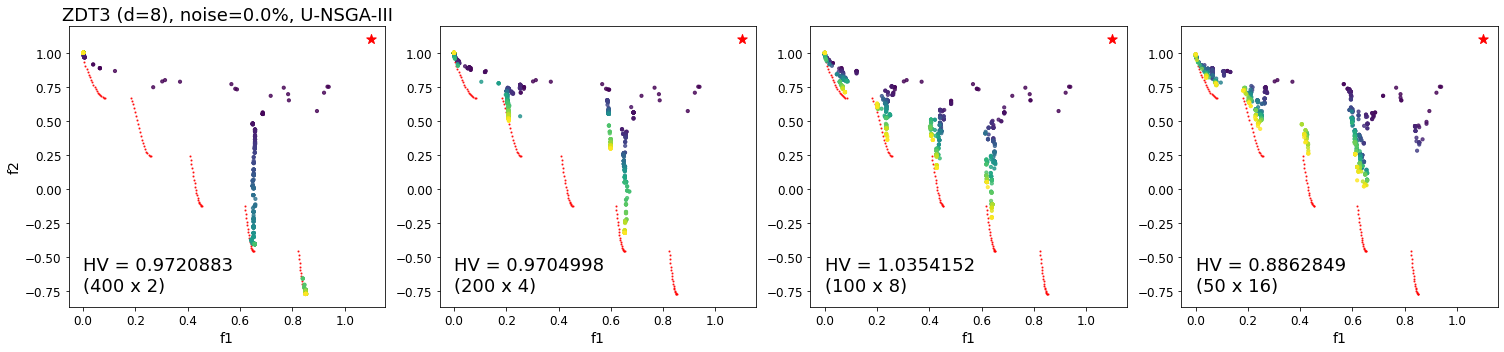

In [70]:
fig, ax = plt.subplots(ncols = 4, figsize = (21,5))

col_list = [0, 1, 2, 3]
train_list = [train_nsga30, train_nsga31, train_nsga32, train_nsga33]
hvs_list = [hvs_nsga30, hvs_nsga31, hvs_nsga32, hvs_nsga33]
n_batch_list = [400, 200, 100, 50]
batch_size_list = [2, 4, 8, 16]

for i, train, hvs, n_batch, batch_size in zip(col_list, train_list, hvs_list, n_batch_list, batch_size_list):
    
    batch_number = torch.cat([torch.zeros(2*(problem.n_var+1)),
                          torch.arange(1, n_batch+1).repeat(batch_size, 1).t().reshape(-1)
                         ]).numpy()

    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=5, marker=".", alpha=0.8)
    
    ax[i].scatter(-train[...,problem.n_var:problem.n_var+problem.n_obj][:,0],
                  -train[...,problem.n_var:problem.n_var+problem.n_obj][:,1],
                 c=batch_number, s=10, alpha=0.8)

    ax[i].scatter(ref_point.cpu().numpy()[0],
                  ref_point.cpu().numpy()[1], 
                  c="r", s=100, marker="*")
    
    ax[i].text(0, -0.75, f"HV = {hvs[-1]:.7f}\n({n_batch} x {batch_size})", fontsize=18)
    
    ax[i].set_xlabel('f1', fontsize=14)
    
    #ax[i].set_xlim(-0.2, 3)
    #ax[i].set_ylim(-0.2, 3)
    
ax[0].set_title(f"ZDT3 (d={dimensions}), noise={noise*100}%, U-NSGA-III", fontsize=18)
ax[0].set_ylabel('f2', fontsize=14)

fig.tight_layout()

In [51]:
ref_point = torch.tensor([1.1,1.1], **tkwargs)
verbose = True
noise = 0.00
problem = Problem_MW7

problem1 = get_problem("mw7")
pareto = problem1.pareto_front()

trial = 1

initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

hvs_nsga30, train_nsga30 = optimize_nsga3(problem, ref_point, initial_x,
                                                 N_BATCH=400, pop_size=2, ref_num=2,
                                                 random_state=trial, noise=noise, verbose=False)
hvs_nsga31, train_nsga31 = optimize_nsga3(problem, ref_point, initial_x,
                                                 N_BATCH=200, pop_size=4, ref_num=4,
                                                 random_state=trial, noise=noise, verbose=False)
hvs_nsga32, train_nsga32 = optimize_nsga3(problem, ref_point, initial_x,
                                                 N_BATCH=100, pop_size=8, ref_num=8,
                                                 random_state=trial, noise=noise, verbose=False)
hvs_nsga33, train_nsga33 = optimize_nsga3(problem, ref_point, initial_x,
                                                 N_BATCH=50, pop_size=16, ref_num=16,
                                                 random_state=trial, noise=noise, verbose=False)

Optimizing with NSGA-III
Time taken in total: 3.08s.
DONE!

Optimizing with NSGA-III
Time taken in total: 2.44s.
DONE!

Optimizing with NSGA-III
Time taken in total: 2.40s.
DONE!

Optimizing with NSGA-III
Time taken in total: 2.19s.
DONE!



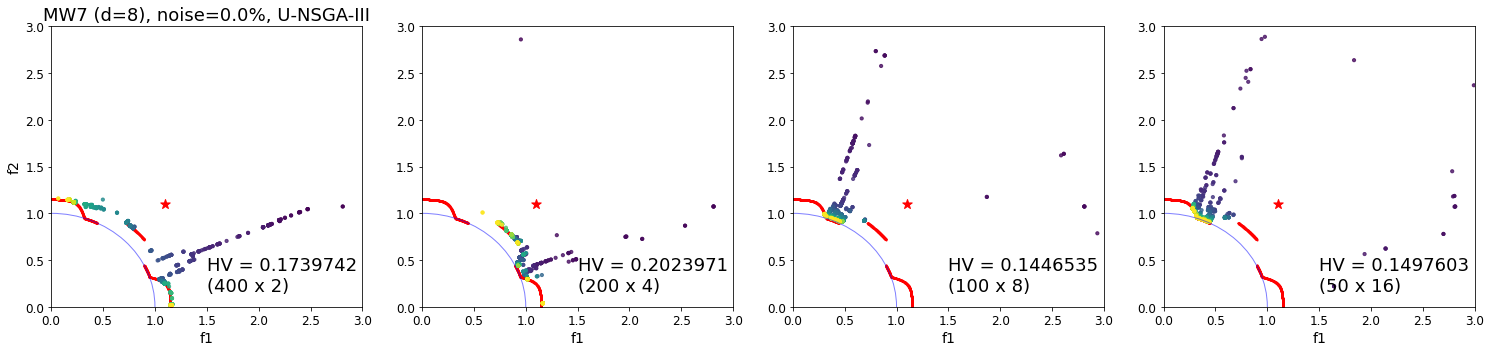

In [64]:
fig, ax = plt.subplots(ncols = 4, figsize = (21,5))

col_list = [0, 1, 2, 3]
train_list = [train_nsga30, train_nsga31, train_nsga32, train_nsga33]
hvs_list = [hvs_nsga30, hvs_nsga31, hvs_nsga32, hvs_nsga33]
n_batch_list = [400, 200, 100, 50]
batch_size_list = [2, 4, 8, 16]

for i, train, hvs, n_batch, batch_size in zip(col_list, train_list, hvs_list, n_batch_list, batch_size_list):
    
    batch_number = torch.cat([torch.zeros(2*(problem.n_var+1)),
                          torch.arange(1, n_batch+1).repeat(batch_size, 1).t().reshape(-1)
                         ]).numpy()

    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=5, marker=".", alpha=0.8)
    
    ax[i].add_patch(plt.Circle((0, 0), 1, color='b', fill=False, alpha=0.5))

    
    ax[i].scatter(-train[...,problem.n_var:problem.n_var+problem.n_obj][:,0],
                  -train[...,problem.n_var:problem.n_var+problem.n_obj][:,1],
                 c=batch_number, s=10, alpha=0.8)

    ax[i].scatter(ref_point.cpu().numpy()[0],
                  ref_point.cpu().numpy()[1], 
                  c="r", s=100, marker="*")
    
    ax[i].text(1.5, 0.17, f"HV = {hvs[-1]:.7f}\n({n_batch} x {batch_size})", fontsize=18)
    
    ax[i].set_xlabel('f1', fontsize=14)
    
    ax[i].set_xlim(0, 3)
    ax[i].set_ylim(0, 3)
    
ax[0].set_title(f"MW7 (d={dimensions}), noise={noise*100}%, U-NSGA-III", fontsize=18)
ax[0].set_ylabel('f2', fontsize=14)

fig.tight_layout()

C:\Users\user\AppData\Local\Temp\ipykernel_2116\3775548592.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  pareto1 = get_problem("zdt1").pareto_front()
C:\Users\user\AppData\Local\Temp\ipykernel_2116\3775548592.py:7: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  pareto2 = get_problem("zdt2").pareto_front()
C:\Users\user\AppData\Local\Temp\ipykernel_2116\3775548592.py:8: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  pareto3 = get_problem("zdt3").pareto_front()
C:\Users\user\AppData\Local\Temp\ipykernel_2116\3775548592.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_

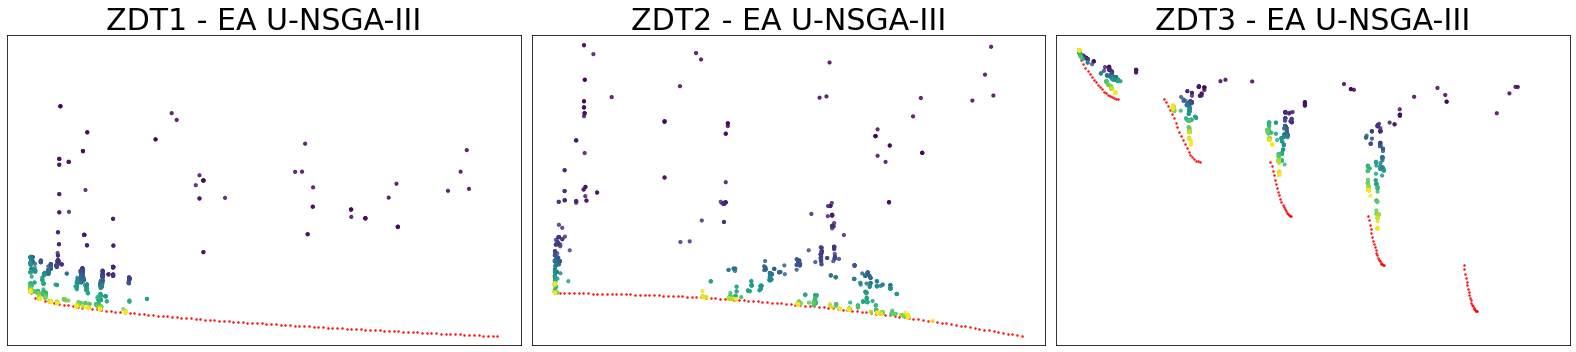

In [41]:
N_BATCH = 100
BATCH_SIZE = 8

problem = Problem_ZDT1

pareto1 = get_problem("zdt1").pareto_front()
pareto2 = get_problem("zdt2").pareto_front()
pareto3 = get_problem("zdt3").pareto_front()

train1 = np.array(loadtxt("ZDT1_train_nsga3_100by8.csv",  delimiter=',')).reshape((N_BATCH*BATCH_SIZE)+2*(dimensions+1), dimensions+2)    
train2 = np.array(loadtxt("ZDT2_train_nsga3_100by8.csv",  delimiter=',')).reshape((N_BATCH*BATCH_SIZE)+2*(dimensions+1), dimensions+2)    
train3 = np.array(loadtxt("ZDT3_train_nsga3_100by8.csv",  delimiter=',')).reshape((N_BATCH*BATCH_SIZE)+2*(dimensions+1), dimensions+2)    

cm = plt.cm.get_cmap('viridis')

fig, ax = plt.subplots(ncols = 3, nrows=1, figsize = (22,5))

batch_number = torch.cat([torch.zeros(2*(problem.n_var+1)),
                          torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)
                         ]).numpy()

for i, train, pareto, problemname in zip([0,1,2],
                                         [train1, train2, train3],
                                         [pareto1, pareto2, pareto3],
                                        ['ZDT1', 'ZDT2', 'ZDT3']):

    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=10, marker=".", alpha=0.8)
    
    ax[i].scatter(-train[...,problem.n_var:problem.n_var+problem.n_obj][:,0],
                  -train[...,problem.n_var:problem.n_var+problem.n_obj][:,1],
                 c=batch_number, cmap=cm, s=10, alpha=0.8)

    ax[i].set_title(f"{problemname} - EA U-NSGA-III", fontsize=30)
    
    ax[i].set(ylabel=None, yticklabels=[], xlabel=None, xticklabels=[])
    ax[i].tick_params(left=False, bottom=False)
        

        
ax[0].set_xlim(-0.05, 1.05)
ax[0].set_ylim(-0.2, 7)
    
ax[1].set_xlim(-0.05, 1.05)
ax[1].set_ylim(-0.2, 7.0)

ax[2].set_xlim(-0.05, 1.05)
ax[2].set_ylim(-1.0, 1.1)




#ax[1].set(ylabel=None, yticklabels=[], xlabel=None, xticklabels=[])
#ax[1].tick_params(left=False)



#plt.setp(ax, xlim=ax[1].get_xlim(), ylim=ax[1].get_ylim())

fig.tight_layout()

C:\Users\user\AppData\Local\Temp\ipykernel_2116\2741159992.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  pareto1 = get_problem("zdt1").pareto_front()
C:\Users\user\AppData\Local\Temp\ipykernel_2116\2741159992.py:7: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  pareto2 = get_problem("zdt2").pareto_front()
C:\Users\user\AppData\Local\Temp\ipykernel_2116\2741159992.py:8: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  pareto3 = get_problem("zdt3").pareto_front()
C:\Users\user\AppData\Local\Temp\ipykernel_2116\2741159992.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_

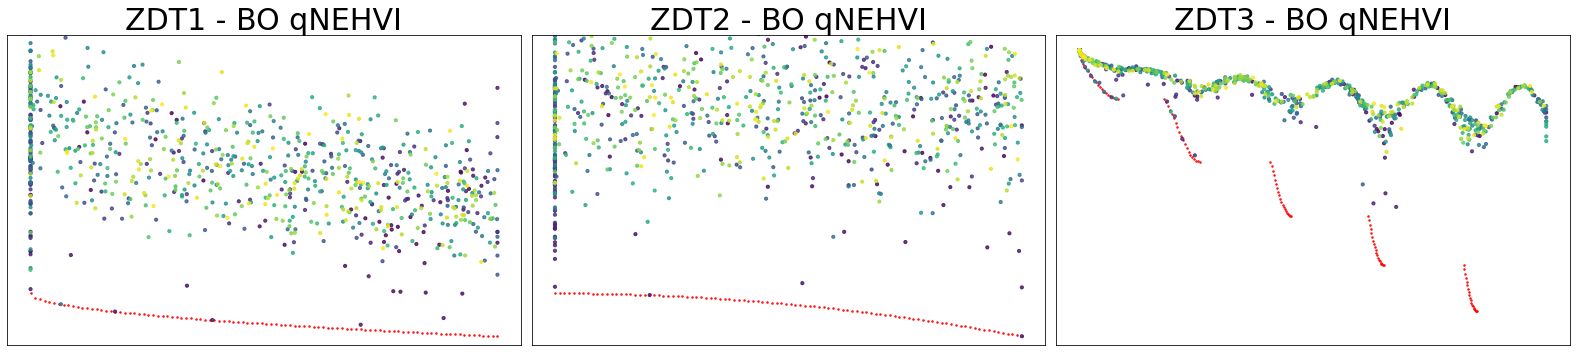

In [42]:
N_BATCH = 100
BATCH_SIZE = 8

problem = Problem_ZDT1

pareto1 = get_problem("zdt1").pareto_front()
pareto2 = get_problem("zdt2").pareto_front()
pareto3 = get_problem("zdt3").pareto_front()

train1 = np.array(loadtxt("ZDT1_train_qnehvi_100by8.csv",  delimiter=',')).reshape((N_BATCH*BATCH_SIZE)+2*(dimensions+1), dimensions+2)    
train2 = np.array(loadtxt("ZDT2_train_qnehvi_100by8.csv",  delimiter=',')).reshape((N_BATCH*BATCH_SIZE)+2*(dimensions+1), dimensions+2)    
train3 = np.array(loadtxt("ZDT3_train_qnehvi_100by8.csv",  delimiter=',')).reshape((N_BATCH*BATCH_SIZE)+2*(dimensions+1), dimensions+2)    

cm = plt.cm.get_cmap('viridis')

fig, ax = plt.subplots(ncols = 3, nrows=1, figsize = (22,5))

batch_number = torch.cat([torch.zeros(2*(problem.n_var+1)),
                          torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)
                         ]).numpy()

for i, train, pareto, problemname in zip([0,1,2],
                                         [train1, train2, train3],
                                         [pareto1, pareto2, pareto3],
                                        ['ZDT1', 'ZDT2', 'ZDT3']):

    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=10, marker=".", alpha=0.8)
    
    ax[i].scatter(-train[...,problem.n_var:problem.n_var+problem.n_obj][:,0],
                  -train[...,problem.n_var:problem.n_var+problem.n_obj][:,1],
                 c=batch_number, cmap=cm, s=10, alpha=0.8)

    ax[i].set_title(f"{problemname} - BO qNEHVI", fontsize=30)
    
    ax[i].set(ylabel=None, yticklabels=[], xlabel=None, xticklabels=[])
    ax[i].tick_params(left=False, bottom=False)
        

        
ax[0].set_xlim(-0.05, 1.05)
ax[0].set_ylim(-0.2, 7)
    
ax[1].set_xlim(-0.05, 1.05)
ax[1].set_ylim(-0.2, 7.0)

ax[2].set_xlim(-0.05, 1.05)
ax[2].set_ylim(-1.0, 1.1)


#ax[1].set(ylabel=None, yticklabels=[], xlabel=None, xticklabels=[])
#ax[1].tick_params(left=False)



#plt.setp(ax, xlim=ax[1].get_xlim(), ylim=ax[1].get_ylim())

fig.tight_layout()

C:\Users\user\AppData\Local\Temp\ipykernel_2116\3840182673.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  pareto1 = get_problem("zdt1").pareto_front()


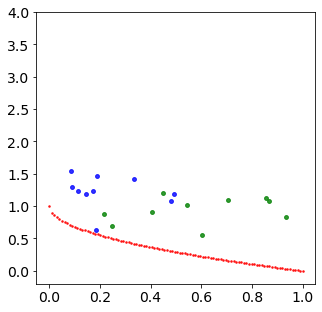

In [78]:
fig, ax = plt.subplots(ncols = 1, nrows=1, figsize = (5,5))

pareto1 = get_problem("zdt1").pareto_front()
ax.scatter(pareto1[:,0],pareto1[:,1], c="r", s=10, marker=".", alpha=0.8)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.2, 4)

randomscatter1 = np.random.rand(10,2)
randomscatter1[:,0] = randomscatter1[:,0]/2
randomscatter1[:,1] = randomscatter1[:,1]+0.55

randomscatter2 = np.random.rand(10,2)
randomscatter2[:,0] = randomscatter2[:,0]+0.2
randomscatter2[:,1] = randomscatter2[:,1]+0.35


ax.scatter(randomscatter1[:,0], randomscatter1[:,1], c='b', s=15, alpha=0.8)
ax.scatter(randomscatter2[:,0], randomscatter2[:,1], c='g', s=15, alpha=0.8)